## 회고

- 하이퍼파라미터에서 학습률, 옵티마이저, 에포크 수로 구성을 짜서 모델을 돌려보면서 각각의 차이점들을 보고 배운거 같다.
- 그래프에서 과적합이 발생해서 dropout을 넣어보려고 한다.
- 어디에나 정답은 없는거 같다.
- Resnet50 말고도 다른 모델로도 빨리빨리 돌려볼걸하는 아쉬움이 있다.


1. 데이터 분할 및 전처리
- 훈련 80%, 검증 10%, 테스트 세트 10%로 분리

- 데이터 전처리:
    - 이미지를 224×224 크기로 리사이즈
    - 픽셀 값을 ResNet50 모델에 맞게 정규화

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import RMSprop, Adam
# 데이터셋 로드
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir='C:/Users/2060/Downloads/flower',
    download=False,
    with_info=True,
    as_supervised=True,
)

# 데이터 전처리 함수 정의
BATCH_SIZE = 32
IMG_SIZE = 224

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32)
    #  입력 이미지를 RGB에서 BGR로 변환하는데 ResNet50이 학습된 ImageNet 데이터셋의 전처리 방식과 일치하기 위해서라고 한다.
    image = tf.keras.applications.resnet50.preprocess_input(image)  # ResNet 전용 전처리
    return image, label

#전처리 적용
train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

#셔플 및 배치 생성 
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_batches = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_batches = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

c:\DL_python\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2. 모델 구성

- ResNet50: 
    - ResNet50을 사용하며, include_top=False로 설정하여 기본 분류 레이어를 제외
    - 사전 학습된 가중치를 활용하며 모든 레이어를 고정(trainable=False)
    - 복잡한 이미지 패턴 학습에 유리


In [2]:
def create_model():
    base_model = ResNet50(
        weights='imagenet', 
        include_top=False, 
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    
    # 사전 학습된 레이어 고정
    for layer in base_model.layers:
        layer.trainable = False
    
    # 새 분류기 레이어 구성
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dense(5, activation='softmax')
    ])
    return model

model = create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 1,051,653 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

3. 학습 설정
- 4가지 다른 구성으로 실험

    - 학습률 0.001, RMSprop 옵티마이저, 5 에포크

    - 학습률 0.0001, RMSprop 옵티마이저, 10 에포크

    - 학습률 0.001, Adam 옵티마이저, 5 에포크

    - 학습률 0.0001, Adam 옵티마이저, 10 에포크

In [3]:
configs = [
    {"learning_rate": 0.001, "optimizer": RMSprop, "epochs": 5},
    {"learning_rate": 0.0001, "optimizer": RMSprop, "epochs": 10},
    {"learning_rate": 0.001, "optimizer": Adam, "epochs": 5},
    {"learning_rate": 0.0001, "optimizer": Adam, "epochs": 10}
]


4. 모델 학습 및 결과 저장

In [4]:
# 결과 저장 리스트 초기화
results = []

# 모델 학습 및 결과 기록
for i, config in enumerate(configs):
    print(f"\n--- Running Configuration {i+1} ---")
    
    # 새로운 모델 생성
    model = create_model()
    
    # 옵티마이저 초기화
    optimizer = config["optimizer"](learning_rate=config["learning_rate"])
    
    # 모델 컴파일
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # 모델 학습
    history = model.fit(
        train_batches,
        epochs=config["epochs"],
        validation_data=validation_batches,
        verbose=1
    )
    
    # 테스트 성능 평가
    test_loss, test_accuracy = model.evaluate(test_batches, verbose=1)
    
    # 결과 저장 (학습 이력 및 테스트 성능)
    results.append({
        "config": config,
        "history": history.history,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy
    })



--- Running Configuration 1 ---
Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.6870 - loss: 1.6954 - val_accuracy: 0.8365 - val_loss: 0.4716
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.9112 - loss: 0.2659 - val_accuracy: 0.8965 - val_loss: 0.3714
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.9521 - loss: 0.1503 - val_accuracy: 0.8801 - val_loss: 0.4003
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.9754 - loss: 0.0736 - val_accuracy: 0.8910 - val_loss: 0.3319
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.9757 - loss: 0.0576 - val_accuracy: 0.8992 - val_loss: 0.3545
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9335 - loss: 0.2311

--- Running Configuration 2 ---
Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.7030 - loss: 0.8596 - val_accuracy: 0.8910 - val_loss: 0.3207
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.9203 - loss: 0.2571 - val_accuracy: 0.8

5. 결과 시각화

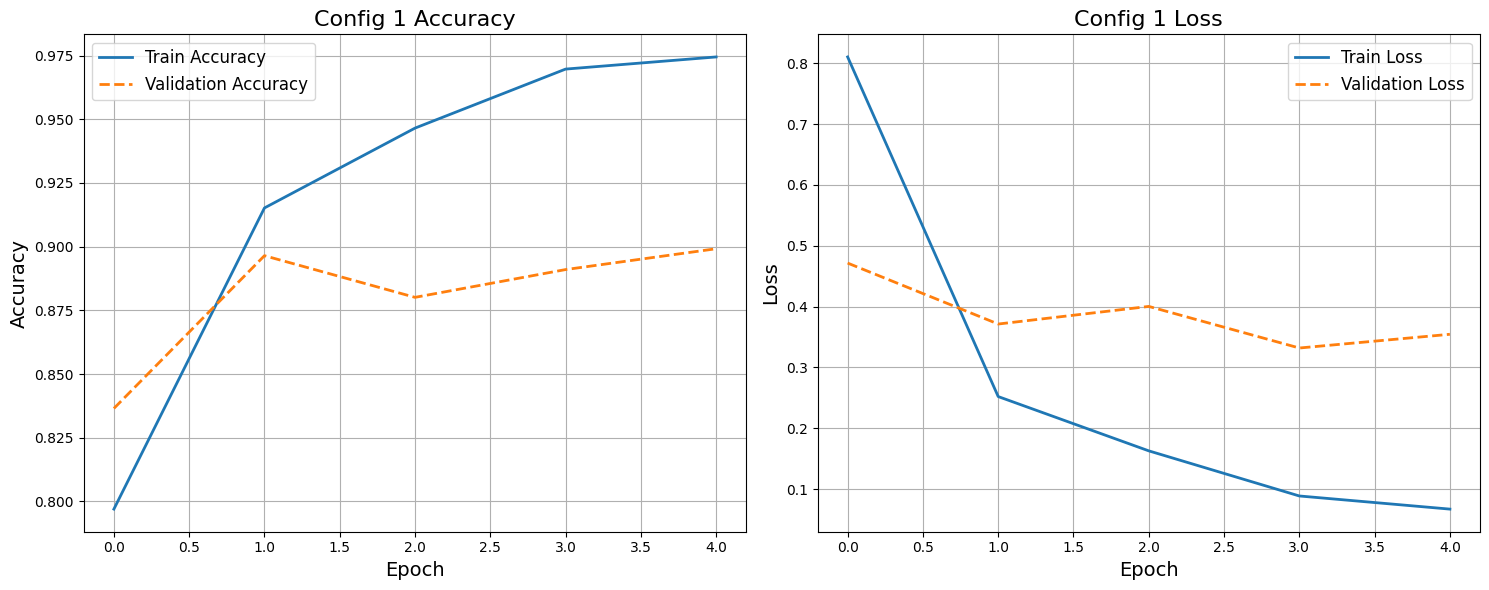

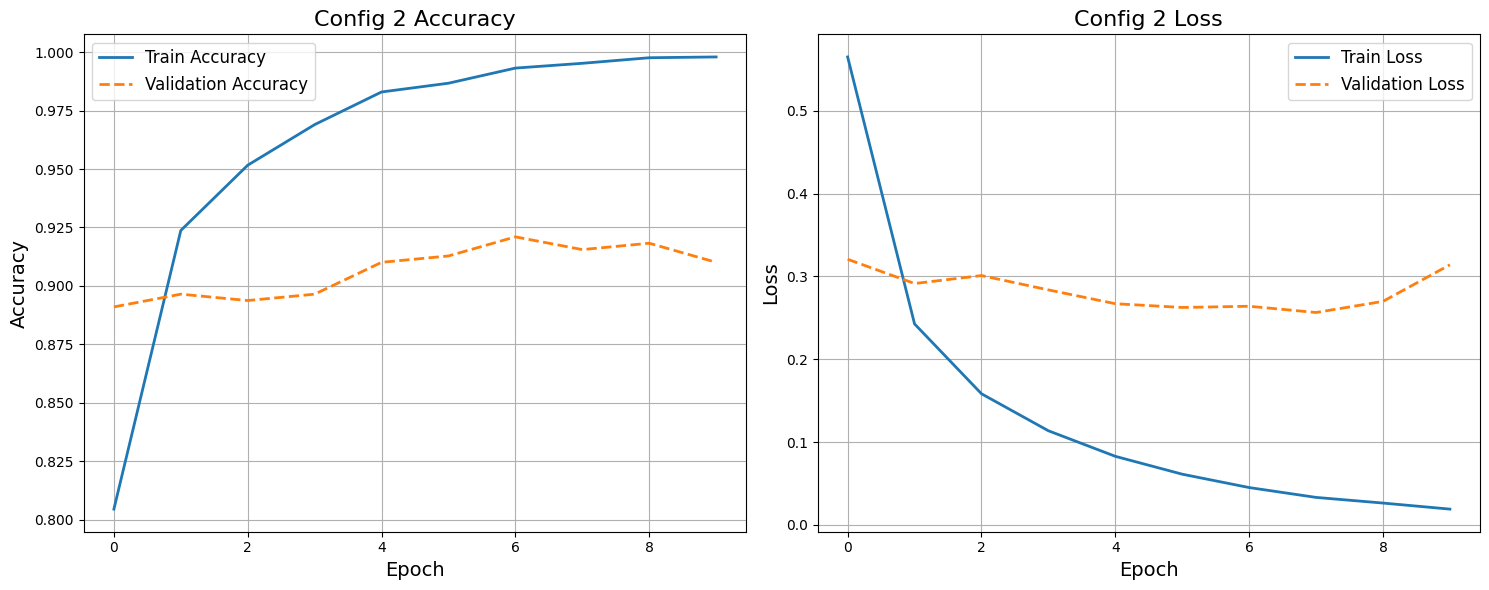

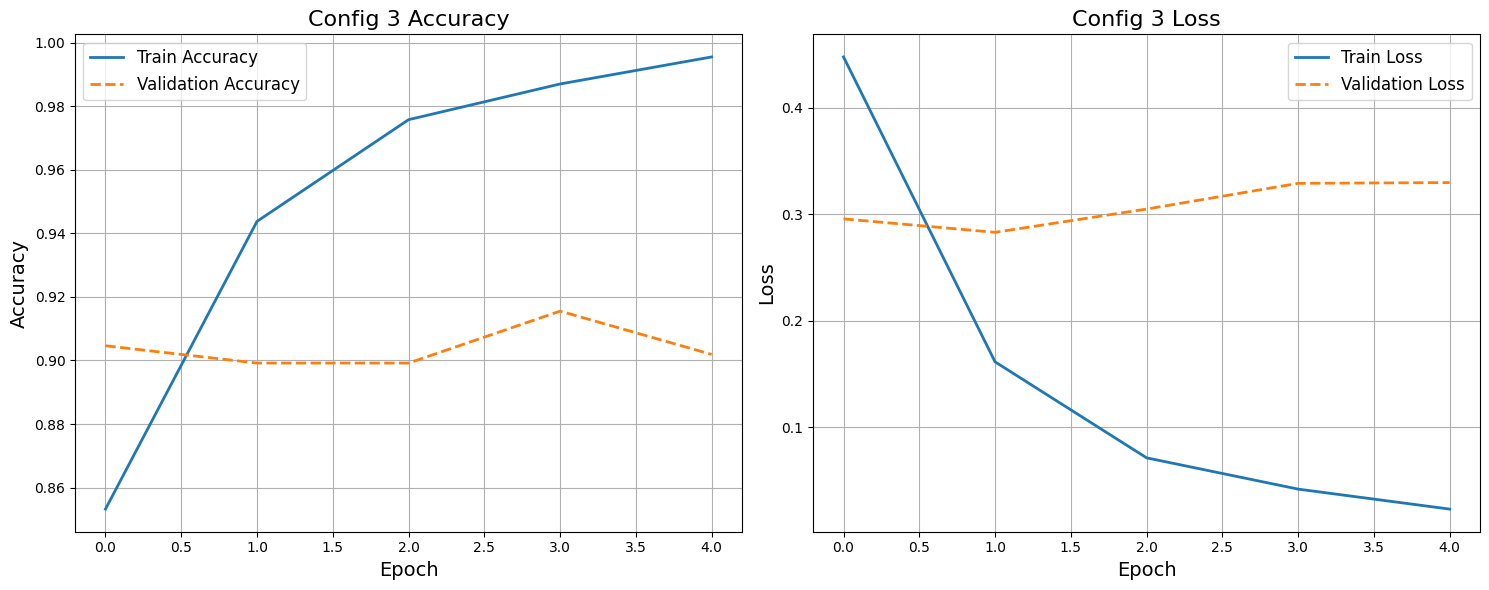

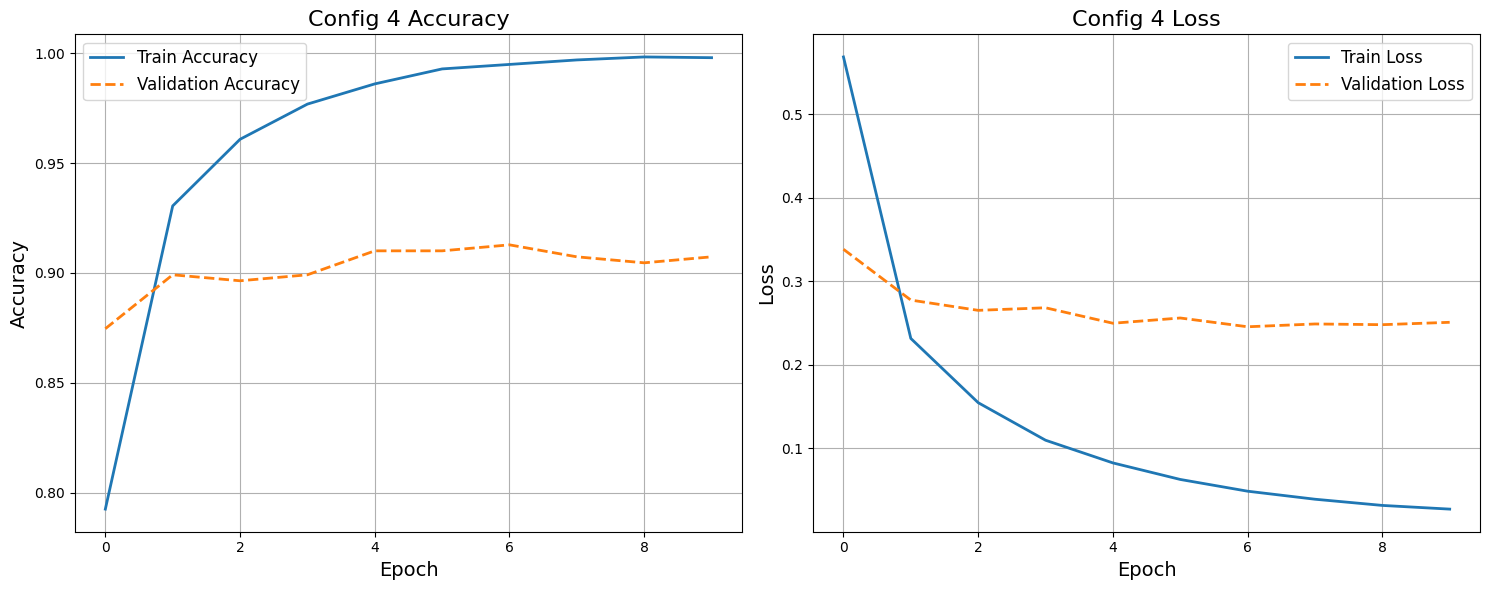

In [5]:
for i, result in enumerate(results):
    plt.figure(figsize=(15, 6))
    
    
    plt.subplot(1, 2, 1) 
    plt.plot(result['history']['accuracy'], label='Train Accuracy', linewidth=2)
    plt.plot(result['history']['val_accuracy'], label='Validation Accuracy', linestyle='--', linewidth=2)
    plt.title(f'Config {i+1} Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True) 
    
    
    plt.subplot(1, 2, 2)  
    plt.plot(result['history']['loss'], label='Train Loss', linewidth=2)
    plt.plot(result['history']['val_loss'], label='Validation Loss', linestyle='--', linewidth=2)
    plt.title(f'Config {i+1} Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)  
    
    plt.tight_layout()
    plt.show()


6. 테스트 성능 출력

In [8]:
# 테스트 성능 출력
for i, result in enumerate(results):
    print(f"\n구성 {i+1}:")
    print(f"학습률: {result['config']['learning_rate']}")
    print(f"옵티마이저: {result['config']['optimizer'].__name__}")
    print(f"테스트 손실: {result['test_loss']:.4f}")
    print(f"테스트 정확도: {result['test_accuracy']:.4f}")



구성 1:
학습률: 0.001
옵티마이저: RMSprop
테스트 손실: 0.2464
테스트 정확도: 0.9237

구성 2:
학습률: 0.0001
옵티마이저: RMSprop
테스트 손실: 0.3165
테스트 정확도: 0.9046

구성 3:
학습률: 0.001
옵티마이저: Adam
테스트 손실: 0.2737
테스트 정확도: 0.9155

구성 4:
학습률: 0.0001
옵티마이저: Adam
테스트 손실: 0.1997
테스트 정확도: 0.9319


- 분석
    - Adam이 RMSprop보다 더 높은 최종 테스트 정확도 달성(Config 4)
    - 동일 학습률에서 Adam이 더 빠른 초기 학습 속도 보임
    - 높은 학습률(0.001)은 빠른 학습을 가능하게 하지만 검증 성능이 불안정
    - 낮은 학습률(0.0001)은 더 안정적인 학습
    - 모든 구성에서 학습 진행될수록 과적합 현상
    - 과적합을 줄이기 위해 드롭아웃을 적용해줘야할거 같다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


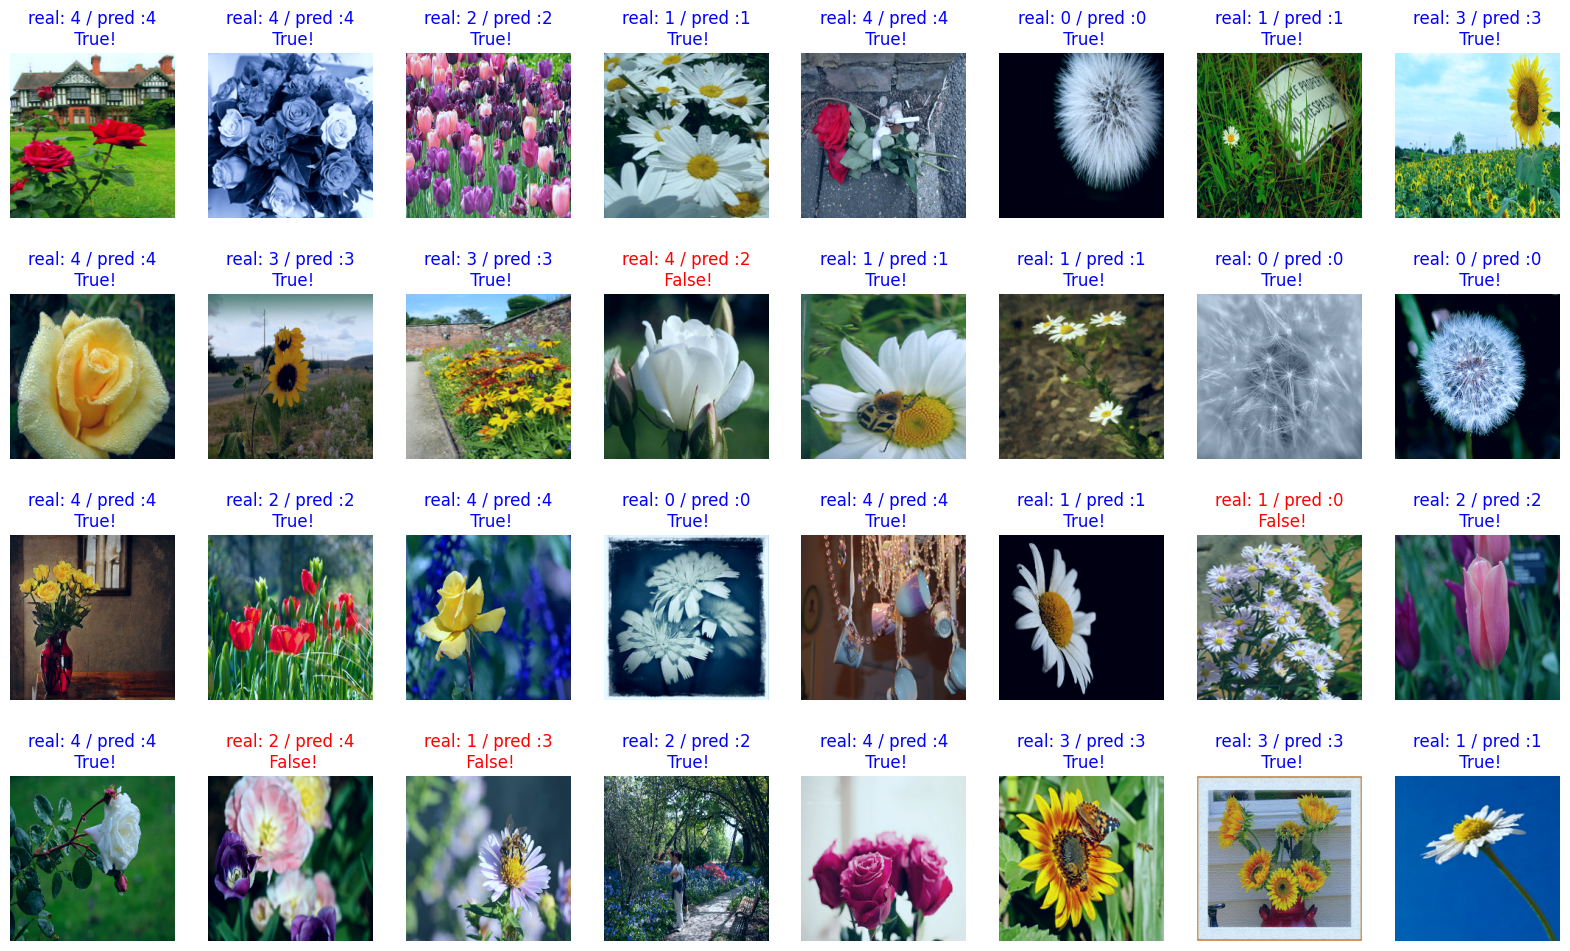

In [12]:
# test_batches에서 첫 번째 배치만 가져옴
for image_batch, label_batch in test_batches.take(2):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    

def denormalize(image):
    # BGR → RGB 변환
    image = image[..., ::-1]
    
    # ImageNet 평균값 복원 (R, G, B 채널별)
    image[..., 0] += 103.939  # Red 채널
    image[..., 1] += 116.779  # Green 채널
    image[..., 2] += 123.68   # Blue 채널
    
    # 픽셀 값 클리핑 (0~255)
    image = np.clip(image, 0, 255).astype("uint8")
    return image

#  모델의 출력에서가장 높은 확률을 가진 클래스 인덱스를 추출
predictions = np.argmax(predictions, axis=1) 

plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    denormalized_image = denormalize(image.numpy())
    plt.imshow(denormalized_image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')